# XStore Benchmarks – Big Experiments

## Libraries

In [1]:
from fabric import ThreadingGroup, Connection
from chi import server, ssh
import os
import warnings
import time
import sys

sys.path.append("../../scripts")
from utilities import *

warnings.filterwarnings("ignore")


## Configurations

In [2]:
sshUser = "ubuntu"
server_ips = ["64.131.114.157"]
server_local_ips = {}
client_ips = ["64.131.114.158"]

storageType = {"HDD": "/HDD", "NVME": "/NVME_RAID-0"}
SERVER_WORKING_DIR = storageType["NVME"]


## Initialize environment

In [3]:
# 1. Create the bastion host connection
bastion = Connection(
    host="matrix-iit",
    user="npatil14",
    forward_agent=True,
    connect_kwargs={
        "key_filename": os.path.expanduser("~/.ssh/id_rsa"),
    },
)

# 2. Create server/client Connections via the gateway
serverConnections = [Connection(ip, user=sshUser, gateway=bastion) for ip in server_ips]
clientConnections = [Connection(ip, user=sshUser, gateway=bastion) for ip in client_ips]

allConnections = serverConnections + clientConnections
serverGroup = ThreadingGroup.from_connections(serverConnections)
clientGroup = ThreadingGroup.from_connections(clientConnections)
allGroup = ThreadingGroup.from_connections(allConnections)

# Get local IP for server
local_ips = serverGroup.run("hostname -I | cut -d ' ' -f 1", hide=True)
for i in local_ips:
    server_local_ips[i.host] = local_ips[i].stdout.strip()


In [4]:
# # Update & Upgrade latest packages
# allGroup.run(f"sudo apt update; sudo apt upgrade -y; sudo shutdown -r +1", hide=True)
# allGroup.close()


Wait for all server to come online after reboot

In [5]:
# # Buffer of reboot
# time.sleep(70)

# for ip in (server_ips + client_ips):
#     server.wait_for_tcp(ip, 22, timeout=1200)


## Datasets

Preparing test datasets on client nodes

In [6]:
# clientGroup.put("../scripts/initData.sh")
# clientGroup.run("bash initData.sh", hide=True)
# clientGroup.close()


## Benchmark server (MongoDB)

Prepare benchmark server

In [6]:
serverGroup.put("../../scripts/XStore/initXStoreServer.sh")
serverGroup.run(
    f"sudo chmod -R 777 {SERVER_WORKING_DIR}; bash initXStoreServer.sh {SERVER_WORKING_DIR} true",
    hide=True,
)
serverGroup.close()


## Benchmark client (XBench)
Prepare benchmark client

In [8]:
# clientGroup.put("../scripts/initXBenchClient.sh")
# clientGroup.run("bash initXBenchClient.sh", hide=True)
# clientGroup.close()


## Experiments - Settings

In [4]:
targetThreads = [1, 2, 4]
numClients = [i * len(client_ips) for i in targetThreads]


## Experiment – UNARY INSERT (SEQ)
**Perform experiments**

In [5]:
runWorkload(
    "INSERT_UNARY_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9497,
    "XStore",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
    bastion,
)


[Benchmark: 1] - Schedule workload on 1746294334
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1746294286 | Delta: 48
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1746294805
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1746294752 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1746295282
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1746295229 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


**Visualization**

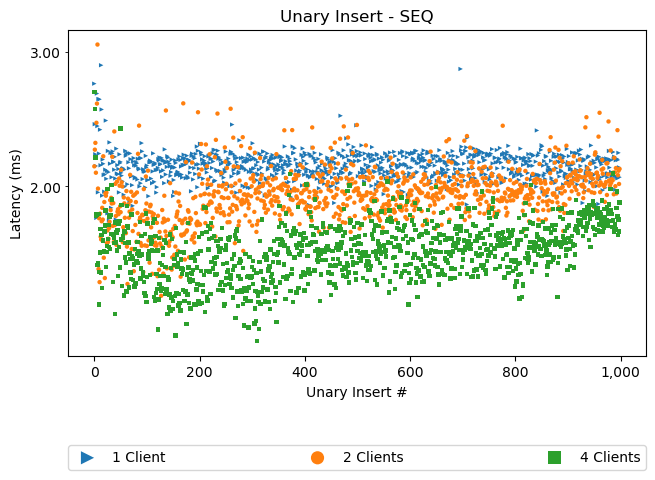

In [6]:
unaryPlots("INSERT_UNARY_SEQ", "XStore", targetThreads, client_ips, logScale=True)


## Experiment – BATCH INSERT (SEQ)
**Perform experiments**

In [8]:
runWorkload(
    "INSERT_BATCH_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9497,
    "XStore",
    client_ips,
    1000,
    10,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
    bastion,
)


[Benchmark: 1] - Schedule workload on 1746296833
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1746296785 | Delta: 48
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1746297304
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1746297256 | Delta: 48
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1746297780
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1746297732 | Delta: 48
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


**Visualization**

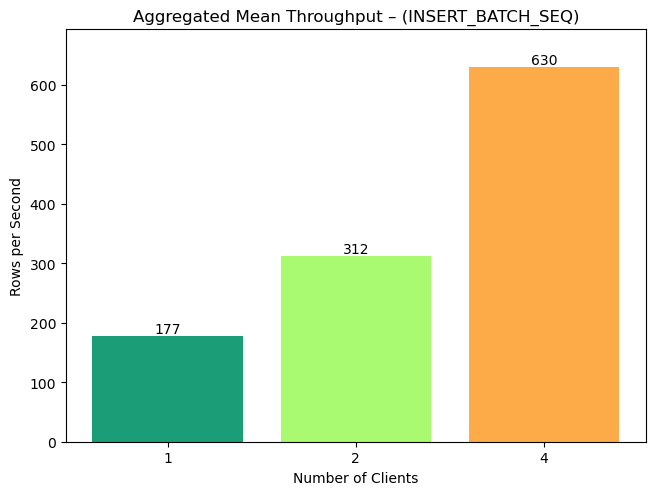

In [9]:
batchPlots("INSERT_BATCH_SEQ", "XStore", targetThreads, client_ips)


## Bootstrap Database

Reboot server to a fresh state to avoid becoming non-accessible from public network

In [18]:
# allGroup.run(f"sudo shutdown -r +1", hide=True)
# allGroup.close()

# # Buffer of reboot
# time.sleep(70)

# for ip in (server_ips + client_ips):
#     server.wait_for_tcp(ip, 22, timeout=1200)


<div class="alert alert-block alert-info">Note: This is required so that there's actual data for clients to query from</div>

In [19]:
# serverGroup.put("../scripts/restoreDB.sh")
# serverGroup.close()

# # Restore DB
# serverGroup.run(f"bash restoreDB.sh CHI@UC MongoDB {SERVER_WORKING_DIR}", hide=True)
# serverGroup.close()

# # Keep checking if job is done running in tmux window
# checkTmuxJobIsDone(serverGroup)


## Experiment – UNARY QUERY (SEQ)

**Perform experiments**

In [ ]:
runWorkload(
    "QUERY_UNARY_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9497,
    "XStore",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
    bastion,
)


**Visualization**

In [ ]:
unaryPlots("QUERY_UNARY_SEQ", "XStore", targetThreads, client_ips, logScale=True)


## Experiment – UNARY QUERY (RAND)

**Perform experiments**

In [ ]:
runWorkload(
    "QUERY_UNARY_RAND",
    targetThreads,
    server_local_ips[server_ips[0]],
    9497,
    "XStore",
    client_ips,
    1000,
    0,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
    bastion,
)


**Visualization**

In [ ]:
unaryPlots("QUERY_UNARY_RAND", "XStore", targetThreads, client_ips)


## Experiment – BATCH QUERY (SEQ)

**Perform experiments**

In [ ]:
runWorkload(
    "QUERY_BATCH_SEQ",
    targetThreads,
    server_local_ips[server_ips[0]],
    9497,
    "XStore",
    client_ips,
    1000,
    10,
    serverGroup,
    SERVER_WORKING_DIR,
    "ubuntu",
    bastion,
)


**Visualization**

In [ ]:
batchPlots("QUERY_BATCH_SEQ", "XStore", targetThreads, client_ips, 100)
